# Our libraries

In [1]:
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from  sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, TensorDataset
import functools
import operator

# The helper functions for plotting and creating a pytorch dataset

In [2]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()
device = set_device()

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y
        
    def __len__(self):
        return self.tensors[0].size(0)    

GPU is enabled in this notebook.


# Loading the preprocessed data and process it further more

In [32]:
# loading the preprocessed data
melspectrogram= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
chroma_stft= np.load('/content/drive/MyDrive/NMA_DL_project/feature_3.npy')
labels= np.load('/content/drive/MyDrive/NMA_DL_project/all_the_labels.npy')

# compining both features and adding the channel dimention
compined_feat= np.concatenate( (melspectrogram , chroma_stft ), axis=1).reshape( 2970,1,140, 108)

x_train , x_test , y_train , y_test = train_test_split( compined_feat , labels , train_size=0.75, stratify=labels )

x_val , x_test , y_val , y_test= train_test_split( x_test , y_test , train_size=0.5 , stratify= y_test )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)
x_val= torch.tensor(x_val)
y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_val=  torch.tensor(y_val)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train)) #,  transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))
val_dataset= CustomTensorDataset(tensors=(x_val, y_val))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=32)
test_loader=torch.utils.data.DataLoader(test_dataset )
val_loader=torch.utils.data.DataLoader(val_dataset ,batch_size=32)

# Building the model

In [4]:
class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 64, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.3),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 512 ) ,
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

# Creating the training loop

In [39]:
def train(model, device, train_loader, validation_loader, epochs , lr ):
  criterion =  nn.CrossEntropyLoss( )
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99 )
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      if epoch%5==0 & epoch>0:
         for param_group in optimizer.param_groups:
                param_group['lr'] /= 5
                print('new lr=' , param_group['lr'] )
       
      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device, dtype=torch.float ), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()

        # Get the Loss
        all_linear1_params = torch.cat( [x.view(-1) for x in model.parameters()]) 
        all_linear2_params = torch.cat( [x.view(-1) for x in model.parameters()])
        l1_regularization = 0.001 * torch.norm(all_linear1_params, 1)
        l2_regularization = 0.5 * torch.norm(all_linear2_params, 2) # this is the one


        loss  = criterion(output, target)  + l2_regularization + l1_regularization
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)
      print(f'Epoch: {epoch+1}')
      print(f'The Train accuracy= {train_acc[epoch]} \n The Validation acc {validation_acc[epoch]}') 
      print(f'The Train loss= {train_loss[epoch]} \n The Validation loss {validation_loss[epoch]}')  
      print('\n')

  return train_loss, train_acc, validation_loss, validation_acc


# Training the model

Epoch: 1
The Train accuracy= 0.22272114952851368 
 The Validation acc 0.3423180592991914
The Train loss= 48.68663024902344 
 The Validation loss 1.7716091672579448


Epoch: 2
The Train accuracy= 0.3929052537045353 
 The Validation acc 0.40431266846361186
The Train loss= 47.28042984008789 
 The Validation loss 1.572541207075119


Epoch: 3
The Train accuracy= 0.4360125729681186 
 The Validation acc 0.4636118598382749
The Train loss= 45.739933013916016 
 The Validation loss 1.4990199108918507


Epoch: 4
The Train accuracy= 0.5002245172878311 
 The Validation acc 0.5040431266846361
The Train loss= 43.962684631347656 
 The Validation loss 1.375054230292638


Epoch: 5
The Train accuracy= 0.5711719802424786 
 The Validation acc 0.5148247978436657
The Train loss= 42.103702545166016 
 The Validation loss 1.346307138601939


Epoch: 6
The Train accuracy= 0.6264032330489447 
 The Validation acc 0.6226415094339622
The Train loss= 40.25911331176758 
 The Validation loss 1.1403768360614777


Epoch: 7

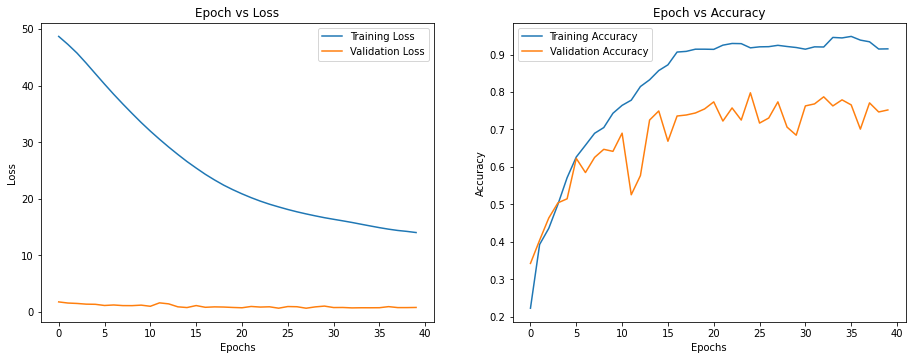

In [40]:
net = music_CNN().to(device)
init_lr = 0.0001
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 40, init_lr)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# Testing on Test set

In [49]:
criterion =  nn.CrossEntropyLoss()
running_loss=0
total=0
correct=0
test_loss=[]
test_acc=[]
for data, target in test_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        test_loss.append(running_loss/len(test_loader))
        test_acc.append(correct/total)

print(f'The test acc {np.mean(test_acc)}') 
print(f'The test loss {np.mean(test_loss)}')  

The test acc 0.7339060973363897
The test loss 0.3820257244291893


# Saving the model with val accuracy 81%

In [50]:
torch.save(net.state_dict(), 'regularized_model.cp')

In [55]:
tmp_model= music_CNN()
tmp_model.load_state_dict(torch.load( 'regularized_model.cp' ))

<All keys matched successfully>

In [62]:
def validate_model(model):
    criterion =  nn.CrossEntropyLoss()
    running_loss=0
    total=0
    correct=0
    for data, target in test_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        test_loss.append(running_loss/len(test_loader))
        test_acc.append(correct/total)

    print(f'The Validation acc {np.mean(test_acc)}') 
    print(f'The Validation loss {np.mean(test_loss)}')  
    print('\n')

validate_model(tmp_model.to('cuda') )

The Validation acc 0.4712194567104732
The Validation loss 0.7509206928101266




copying the trained model into my drive

In [63]:
!cp  '/content/regularized_model.cp' '/content/drive/MyDrive/NMA_DL_project'

# Testing

In [ ]:
def classify_music( path ):
    import librosa
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning,)
    classes=[ 'classical ', 'hiphop', 'pop','country',
                     'disco', 'reggae', 'jazz', 'rock', 'blues', 'metal']
    music_loc= path # insert path for the audio wav file prefereably
    y, sr = librosa.load(music_loc)
    y_resamble= librosa.resample(y[110299:110299*2], 22050, 11025)
    C_STFT= librosa.feature.chroma_stft( y_resamble, sr=11025  )
    S = librosa.feature.melspectrogram( y_resamble, sr=11025  )
    S_DB = librosa.amplitude_to_db(S, ref=np.max)
    input_test= np.concatenate( (S_DB , C_STFT), axis=0).reshape( 1,1,140, 108)
    input_test=torch.tensor(input_test, device='cuda')
    # we are using the tmp_model that I saved it's weights b4

    idx= torch.argmax(F.softmax( tmp_model( input_test ).to('cuda') , dim=0  )) 
    return print(f' Genre is: {classes[idx]}')


In [ ]:
classify_music( '/content/jazz_song.mp3' ) # this is let's face the music and dance song by nat king cole